In [15]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import community
from collections import Counter


def parseDataset(path):
    df = pd.read_table(path, delimiter='\t', names=['source','target'])
    return nx.from_pandas_edgelist(df,"source","target")

def parseJson(path):
    with open(path) as f:
        data = json.load(f)
        return nx.node_link_graph(data)



In [21]:
#Graph creation
dataset_path= "reducer/all_datas.json"
#G = parseDataset("dataset.txt")
#reduced = False
#has_foci= False
G= parseJson(dataset_path)
reduced = True
has_foci= True

In [22]:
#generic analysis
print(G)


Graph with 24568 nodes and 19898 edges


In [23]:
#distances analysis (ci metterà una vita, la giant component richiederà ore)
if reduced:
    distances_sum = 0
    all_p = []
    connected_components_list = sorted(nx.connected_components(G), key=len, reverse=True)
    examined_components= 0
    for C in (G.subgraph(c).copy() for c in connected_components_list):
        p = dict(nx.shortest_path_length(C)) #questo conterrà tutte le distanze, per poter guardare max, min e media
        all_p.append(p)
        distance = nx.average_shortest_path_length(C)
        if distances_sum == 0:
            print("average path largest connected component= :" + str(distance))
        if distance > 0:
            examined_components += 1
            distances_sum += distance


    print("Average distance: ", distances_sum/examined_components)


average path largest connected component= :5.711863452751257
Average distance:  1.1026938012428609


In [5]:
#clustering coefficient
print("Clustering coefficient: "+str(nx.average_clustering(G)))


Clustering coefficient: 0.17232592744613273


Come si spiega questo valore? la discussione che abbiamo fatto di persona ( non ci sono grossi hubs, diciamo che le comunità sono degli hub). ciò si spiega anche con il discorso dei foci, abbiamo dei luogi in cui tantissime persone vanno.
ci sono ulteriori prove di ciò qui:
http://snap.stanford.edu/data/loc-brightkite.html
Si può notare che i triangoli chiusi sono pochissimi e quindi il clustering coefficient è basso.

Il grafo è connesso? False
Componenti connesse: 547
largest connected component size: 56739
[56739, 49, 11, 11, 10, 10, 9, 8, 8, 7, 7, 7, 6, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2

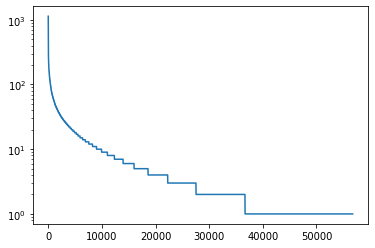

In [6]:
#largest connected component
print("Il grafo è connesso? "+str(nx.is_connected(G)))
print("Componenti connesse: "+ str(nx.number_connected_components(G)))
core_nodes = max(nx.connected_components(G), key=len)
print(f"largest connected component size: {len(core_nodes)}")
core = G.subgraph(core_nodes)
print([len(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)])

#analizzo i degree all'interno della sola largest connected components per scoprire se la sua dimensione è dovuta a molti nodi che si incontrano oppure a supernodi Hub
largest_component = G.subgraph(core_nodes).copy()
core_degree_sequence = sorted([d for n, d in largest_component.degree()], reverse=True)  # degree sequence
plt.yscale('log')
plt.plot(core_degree_sequence)
#nx.draw(core, with_labels=True)

average degree: 7.353094731057223
21157
1
degree sequence: [1134, 1055, 854, 838, 833, 779, 732, 569, 550, 475, 467, 453, 448, 404, 386, 379, 354, 343, 337, 334, 333, 332, 327, 326, 325, 321, 311, 310, 306, 301, 299, 296, 292, 289, 282, 274, 272, 271, 270, 270, 270, 267, 267, 266, 264, 259, 257, 256, 254, 253, 253, 248, 242, 241, 230, 230, 228, 228, 228, 227, 226, 225, 225, 221, 218, 218, 215, 214, 214, 213, 213, 212, 211, 210, 210, 210, 210, 209, 207, 206, 206, 205, 204, 203, 202, 202, 202, 201, 201, 198, 198, 194, 193, 192, 192, 191, 190, 190, 190, 190, 190, 189, 188, 188, 187, 186, 185, 184, 184, 183, 181, 180, 179, 178, 178, 177, 176, 176, 175, 175, 175, 174, 173, 173, 173, 173, 173, 172, 172, 172, 172, 172, 172, 171, 171, 170, 170, 169, 168, 168, 168, 168, 168, 167, 167, 166, 166, 166, 165, 164, 163, 163, 163, 163, 162, 162, 162, 162, 162, 162, 161, 161, 161, 160, 160, 160, 160, 159, 158, 158, 157, 156, 155, 155, 153, 153, 153, 153, 152, 151, 151, 150, 150, 150, 149, 149, 149, 149

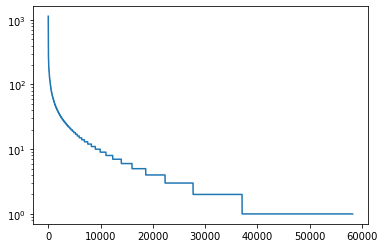

In [7]:
#degree analysis
if not reduced:
    degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
    plt.yscale('log')
    plt.plot(degree_sequence)

    print("average degree: " + str(sum(degree_sequence)/len(degree_sequence)))
    #wtf? average degree 7?
    print(degree_sequence.count(min(degree_sequence)))
    #ah, ecco perchè.
    print(min(degree_sequence))

    print("degree sequence: " + str(degree_sequence))

In [8]:
#Degree correlation
if not reduced:
    print("Degree correlation: "+str(nx.degree_pearson_correlation_coefficient(G)))
    print("Degree correlation: "+str(nx.degree_pearson_correlation_coefficient(largest_component)))

Degree correlation: 0.010815796314560602
Degree correlation: 0.009622679947904226


In [9]:
#community detection
#communities = community_louvain.best_partition(G)
largest_component_communities = community.community_louvain.best_partition(largest_component)
# number of communities
#print(Counter(communities.values()))
print(Counter(largest_component_communities.values()))


Counter({1: 8090, 10: 5443, 3: 5248, 0: 4100, 20: 3740, 6: 2052, 13: 1994, 30: 1800, 16: 1747, 7: 1573, 2: 1385, 11: 1316, 12: 1204, 19: 1125, 18: 984, 28: 977, 9: 954, 49: 939, 42: 936, 21: 894, 23: 736, 37: 699, 24: 663, 32: 541, 17: 501, 71: 470, 15: 455, 27: 426, 29: 406, 47: 401, 8: 400, 44: 342, 48: 323, 45: 309, 14: 279, 58: 274, 25: 273, 34: 263, 51: 224, 38: 176, 41: 175, 26: 170, 50: 140, 53: 130, 4: 103, 46: 100, 61: 93, 55: 86, 63: 58, 83: 57, 73: 44, 88: 40, 5: 32, 67: 30, 76: 30, 66: 25, 31: 22, 86: 22, 102: 21, 33: 20, 22: 19, 85: 16, 107: 16, 108: 14, 75: 13, 118: 13, 126: 13, 146: 12, 39: 11, 78: 11, 121: 11, 143: 11, 149: 11, 151: 11, 54: 10, 74: 10, 79: 10, 99: 10, 130: 10, 131: 10, 140: 10, 155: 10, 35: 9, 105: 9, 109: 9, 127: 9, 141: 9, 156: 9, 52: 8, 80: 7, 81: 7, 87: 7, 91: 7, 111: 7, 148: 7, 157: 7, 57: 6, 69: 6, 82: 6, 90: 6, 95: 6, 97: 6, 100: 6, 104: 6, 110: 6, 116: 6, 123: 6, 125: 6, 134: 6, 150: 6, 152: 6, 153: 6, 40: 6, 68: 6, 36: 5, 59: 5, 65: 5, 72: 5, 9

'si nota subito una grossa comunità centrale (la 1) ma è interessante anche notare che c\'è un cluster di comunità che fungono da "intermediari"\ntra le comunità di sinistra e quelle di destra. la 1 è assolutamente un hub (ed è la comunità più grossa),ma le altre nel mezzo permettono il collegamento.\n'

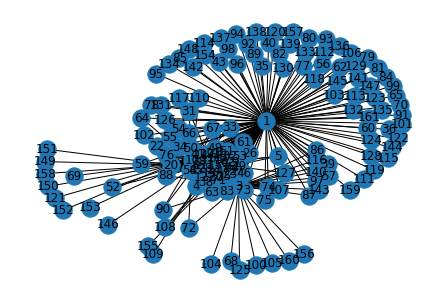

In [10]:
#plt.plot(sorted(Counter(largest_component_communities.values()).values(),reverse=True))
#TODO: aggiustare la dimensione dell'immagine, se si decommenta la linea precedente il grafo delle comunità diventa un amoung us
#per ignorare quelle da due è meglio valutare solo la largest_component
induced_graph = community.induced_graph(largest_component_communities, largest_component, weight='WEIGHT')
induced_graph.remove_edges_from(nx.selfloop_edges(induced_graph))

nx.draw(induced_graph, with_labels=True, pos=nx.spring_layout(induced_graph))
'''si nota subito una grossa comunità centrale (la 1) ma è interessante anche notare che c'è un cluster di comunità che fungono da "intermediari"
tra le comunità di sinistra e quelle di destra. la 1 è assolutamente un hub (ed è la comunità più grossa),ma le altre nel mezzo permettono il collegamento.
'''

In [11]:
#centrality analysis
if reduced:
    print(nx.closeness_centrality(G))
else:
    print("betweenness centrality: "+str(sum(nx.betweenness_centrality(G,k=100).values())/58228))
    #troppo grande per fare closeness_centrality(G)

#sarebbe interessante valutare la betwenness di alcuni nodi particolari

betweenness centrality: 6.441997759659624e-05


average degree: 7.353094731057223
21157
degree sequence: [1134, 1055, 854, 838, 833, 779, 732, 569, 550, 475, 467, 453, 448, 404, 386, 379, 354, 343, 337, 334, 333, 332, 327, 326, 325, 321, 311, 310, 306, 301, 299, 296, 292, 289, 282, 274, 272, 271, 270, 270, 270, 267, 267, 266, 264, 259, 257, 256, 254, 253, 253, 248, 242, 241, 230, 230, 228, 228, 228, 227, 226, 225, 225, 221, 218, 218, 215, 214, 214, 213, 213, 212, 211, 210, 210, 210, 210, 209, 207, 206, 206, 205, 204, 203, 202, 202, 202, 201, 201, 198, 198, 194, 193, 192, 192, 191, 190, 190, 190, 190, 190, 189, 188, 188, 187, 186, 185, 184, 184, 183, 181, 180, 179, 178, 178, 177, 176, 176, 175, 175, 175, 174, 173, 173, 173, 173, 173, 172, 172, 172, 172, 172, 172, 171, 171, 170, 170, 169, 168, 168, 168, 168, 168, 167, 167, 166, 166, 166, 165, 164, 163, 163, 163, 163, 162, 162, 162, 162, 162, 162, 161, 161, 161, 160, 160, 160, 160, 159, 158, 158, 157, 156, 155, 155, 153, 153, 153, 153, 152, 151, 151, 150, 150, 150, 149, 149, 149, 149, 

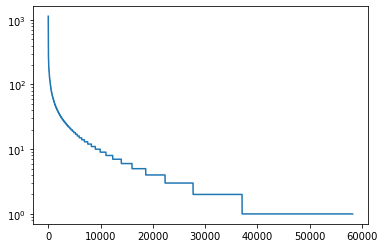

In [12]:
#degree analysis
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
plt.yscale('log')
plt.plot(degree_sequence)

print("average degree: " + str(sum(degree_sequence)/len(degree_sequence)))
#wtf? average degree 7?
print(degree_sequence.count(min(degree_sequence)))
#ah, ecco perchè. molti nodi hanno degree 1

print("degree sequence: " + str(degree_sequence))

In [13]:
#community detection
#communities = community_louvain.best_partition(G)
largest_component_communities = community.community_louvain.best_partition(largest_component)
# number of communities
#print(Counter(communities.values()))
print(Counter(largest_component_communities.values()))
plt.plot(sorted(Counter(largest_component_communities.values()).values(),reverse=True))
#per ignorare quelle da due è meglio valutare solo la largest_component

KeyboardInterrupt: 

In [ ]:
#affiliation analysis
if has_foci:
    foci = {}
    links = list(G.edges(data=True))
    for link in links:
        if link[2]['position'] in foci:
            foci[link[2]['position']] += 1
        else:
            foci[link[2]['position']] = 1

    print(dict(sorted(foci.items(), key=lambda x: x[1], reverse=True)[0:20]))

#ci sono pochi luogi in cui va tantissima gente ( circa il 9%), in pratica il 30% delle persone ha visitato almeno uno di questi 4 posti.